In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

In [2]:
# Load the dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
x = df.head()
print(x)

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


## Description of the dataset

This dataset contains information about patients who have suffered a stroke.

### Columns and their descriptions:

| Column              | Description                                                                            | Data Type            |
| ------------------- | -------------------------------------------------------------------------------------- | -------------------- |
| `id`                | Patient identifier                                                                     | Numeric (ID)         |
| `gender`            | Gender of the patient: `Male`, `Female`, sometimes `Other`                             | Categorical          |
| `age`               | Age of the patient                                                                     | Numeric (continuous) |
| `hypertension`      | Whether the patient has hypertension (`0`: No, `1`: Yes)                               | Numeric (binary)     |
| `heart_disease`     | Whether the patient has heart disease (`0`: No, `1`: Yes)                              | Numeric (binary)     |
| `ever_married`      | Marital status: `Yes`, `No`                                                            | Categorical          |
| `work_type`         | Type of employment: `Private`, `Self-employed`, `Govt_job`, `children`, `Never_worked` | Categorical          |
| `Residence_type`    | Place of residence: `Urban` or `Rural`                                                 | Categorical          |
| `avg_glucose_level` | Average blood glucose level                                                            | Numeric (continuous) |
| `bmi`               | Body Mass Index *(may contain missing values)*                                         | Numeric (continuous) |
| `smoking_status`    | Smoking status: `formerly smoked`, `never smoked`, `smokes`, `Unknown`                 | Categorical          |
| `stroke`            | Whether the patient has had a stroke (`0`: No, `1`: Yes) *(target variable)*           | Numeric (binary)     |



# Data preprocessing

### First problem - missing values

In [3]:
# Check for missing values
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

As we can see, we got 201 empty values in BMI

In [4]:
missing = df["bmi"].isnull().sum()
total = len(df)
print(f"{missing} missing values, is {missing / total:.2%} of the full dataset.")

201 missing values, is 3.93% of the full dataset.


The best solution is to fill the data with the median - as the data is not normally distributed. Let's check the distribution of the data.

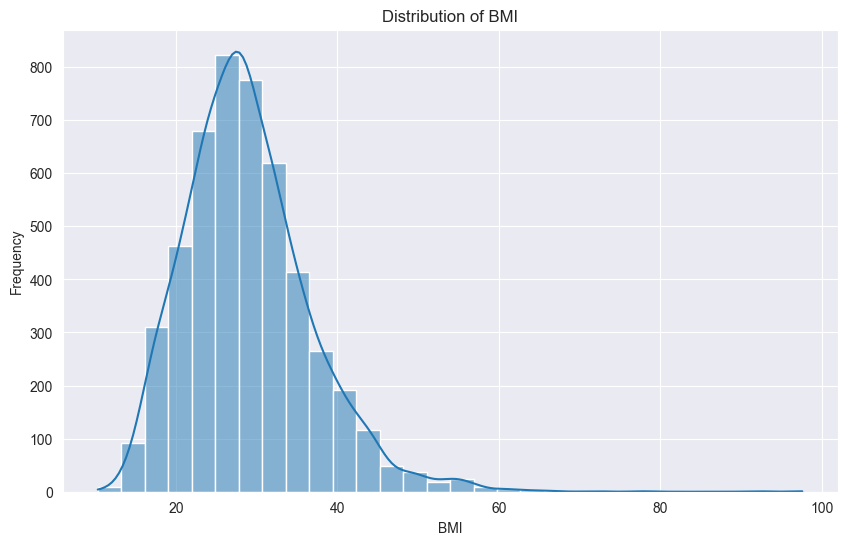

In [5]:
#distribution of the data
plt.figure(figsize=(10, 6))
sns.histplot(df["bmi"], bins=30, kde=True)
plt.title("Distribution of BMI")
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.show()

In [6]:
median_bmi = df["bmi"].median()
df["bmi"].fillna(median_bmi, inplace=True)

C:\Users\jakub\AppData\Local\Temp\ipykernel_15476\3088539898.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["bmi"].fillna(median_bmi, inplace=True)


### Second problem - outliers

In [7]:
df["gender"].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

We got 1 "Other" in gender. The best solution is to drop this row

In [8]:
df = df[df["gender"] != "Other"]

### Third problem - "Unknown" values in smoking status

In [9]:
df["smoking_status"].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64

In [10]:
missing = df["smoking_status"]
counter = 0
for x in missing:
    if x == "Unknown":
        counter += 1
print(f'There is {counter} unknown values in smoking status, which is {counter / len(missing):.2%} of the full dataset.')

There is 1544 unknown values in smoking status, which is 30.22% of the full dataset.


We got 1544 "Unknown" in smoking status. It is too much to drop this row. The best solution is to treat this value as different status.

# One-hot encoding

We will use OneHotEncoder to convert the categorical variables into numerical ones.

In [11]:
categorical_cols = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status"
]

y = df['stroke']
df = df.drop(['id', 'stroke'], axis=1)
df_encoded = pd.get_dummies(df, columns=categorical_cols)
df_encoded = df_encoded.astype(int)

In [12]:
df_encoded.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67,0,1,228,36,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0
1,61,0,0,202,28,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0
2,80,0,1,105,32,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0
3,49,0,0,171,34,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
4,79,1,0,174,24,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0


# Plots

### First we are going to check the distribution of numerical variables

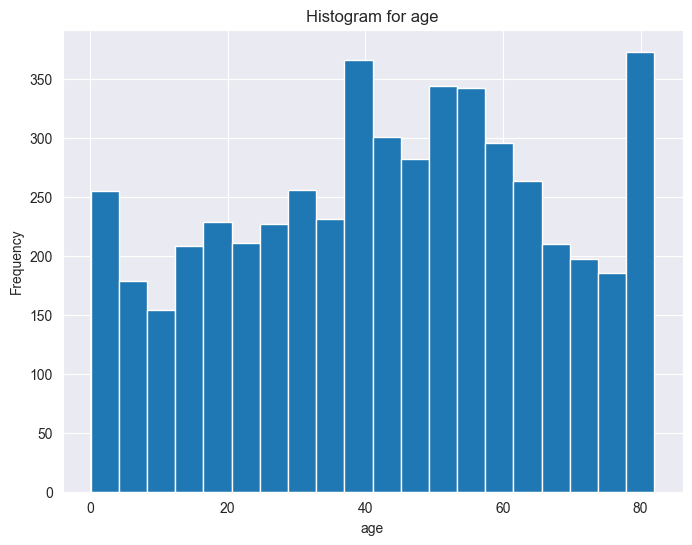

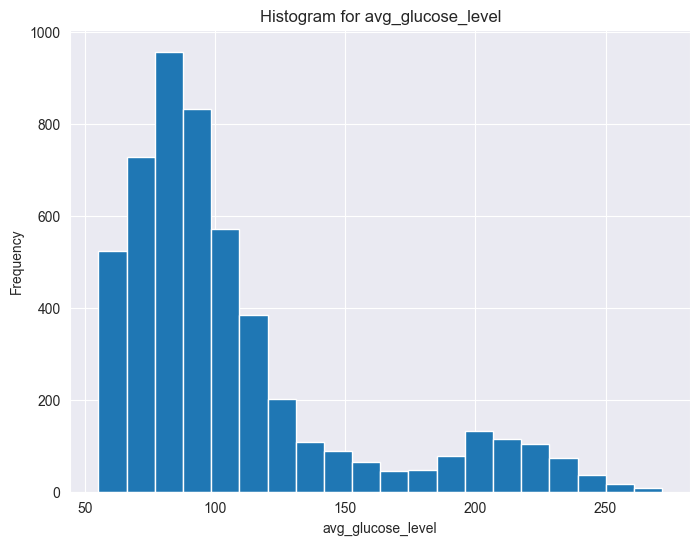

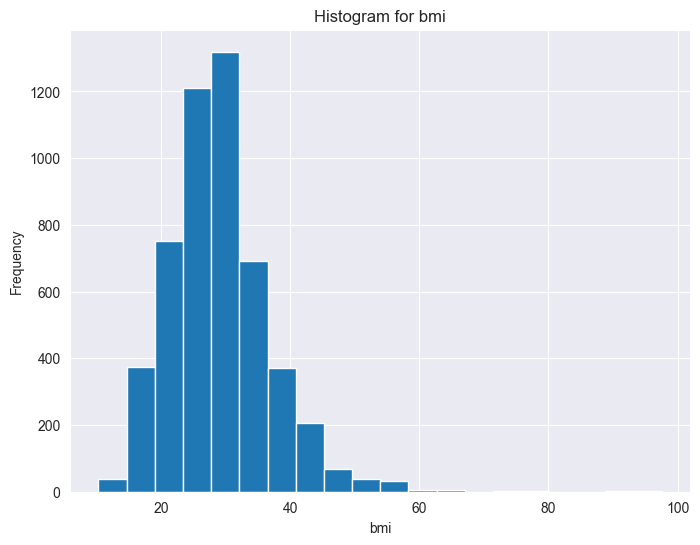

In [13]:
import matplotlib.pyplot as plt

numeric_cols = ['age', 'avg_glucose_level', 'bmi']

for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    df[col].hist(bins=20)
    plt.title(f"Histogram for {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

### Then, for the numerical variables we will check the correlation between them

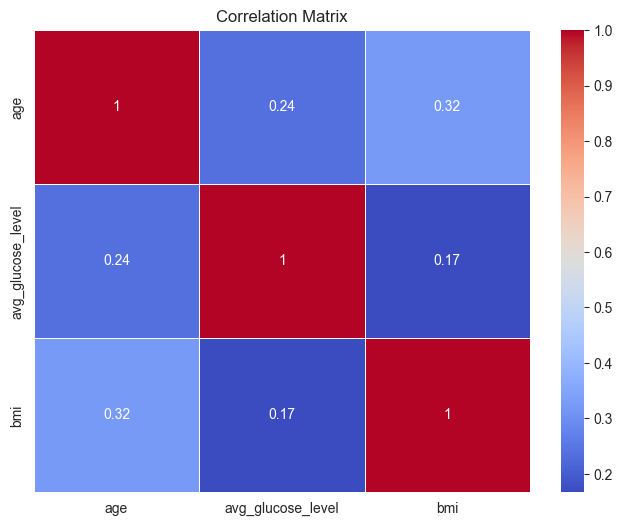

In [14]:
import seaborn as sns

corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

As we can see, there are a weak correlation between age and avg_glucose_level, and a weak correlation between age and bmi. There is no correlation between avg_glucose_level and bmi.

<Axes: xlabel='gender', ylabel='count'>

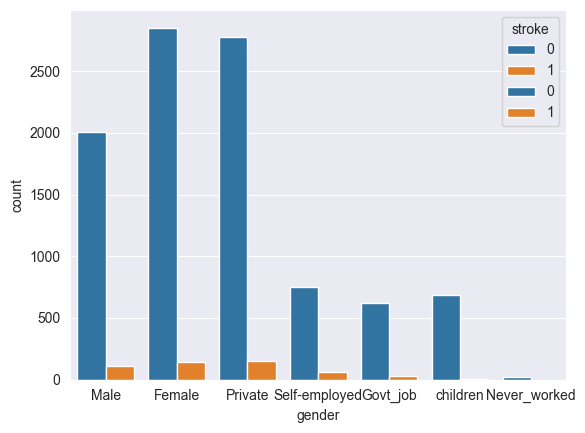

In [17]:
df['stroke'] = y
sns.countplot(x='gender', hue='stroke', data=df)
sns.countplot(x='work_type', hue='stroke', data=df)

In [18]:
pd.crosstab(df['gender'], df['smoking_status'], values=df['stroke'], aggfunc='mean')

smoking_status,Unknown,formerly smoked,never smoked,smokes
gender,,,,
Female,0.029904,0.071279,0.051261,0.042035
Male,0.031073,0.088452,0.040724,0.068249


<Axes: xlabel='stroke'>

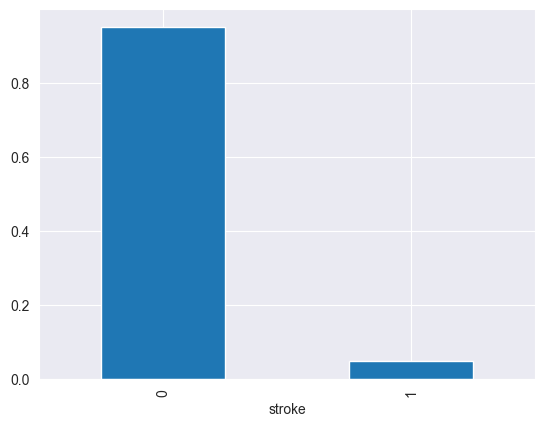

In [19]:
df['stroke'].value_counts(normalize=True).plot(kind='bar')

As we can see we got 95% of people without stroke and 5% of people with stroke. This is a very unbalanced dataset.

# Reducing the dimensionality of the dataset

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_encoded_scaled = scaler.fit_transform(df_encoded)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_encoded_scaled)
df_pca = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
df_pca['stroke'] = y

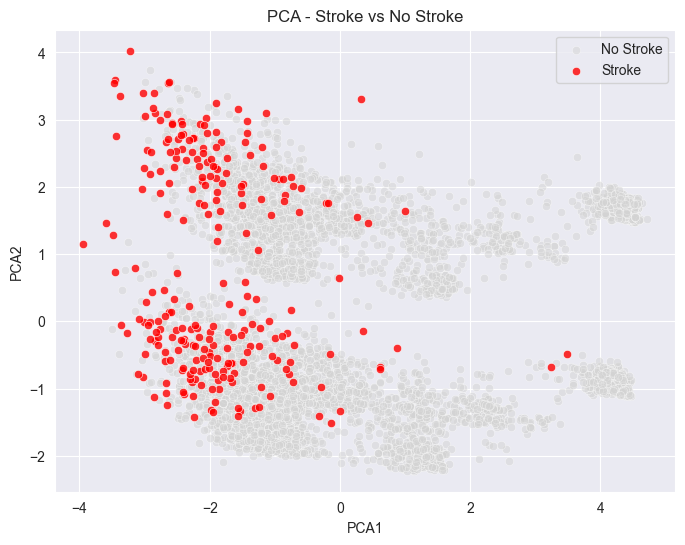

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

#stroke=0
sns.scatterplot( data=df_pca[df_pca['stroke'] == 0], x='PCA1', y='PCA2',color='lightgrey', alpha=0.5,label='No Stroke')

#stroke=1
sns.scatterplot(data=df_pca[df_pca['stroke'] == 1],x='PCA1', y='PCA2',color='red', alpha=0.8,label='Stroke')

plt.title("PCA - Stroke vs No Stroke")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\jakub\PycharmProjects\data_visualization\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jakub\PycharmProjects\data_visualization\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


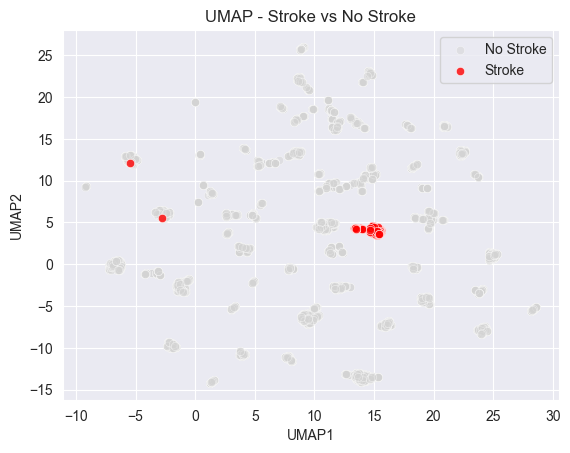

In [23]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns


umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(df_encoded_scaled)
df_umap = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'])
df_umap['stroke'] = y
#stroke=0
sns.scatterplot(data=df_umap[df_umap['stroke'] == 0],x='UMAP1', y='UMAP2',color='lightgrey', alpha=0.5,label='No Stroke')

#stroke=1
sns.scatterplot(data=df_umap[df_umap['stroke'] == 1],x='UMAP1', y='UMAP2',color='red', alpha=0.8,label='Stroke')

plt.title("UMAP - Stroke vs No Stroke")
plt.legend()
plt.grid(True)
plt.show()

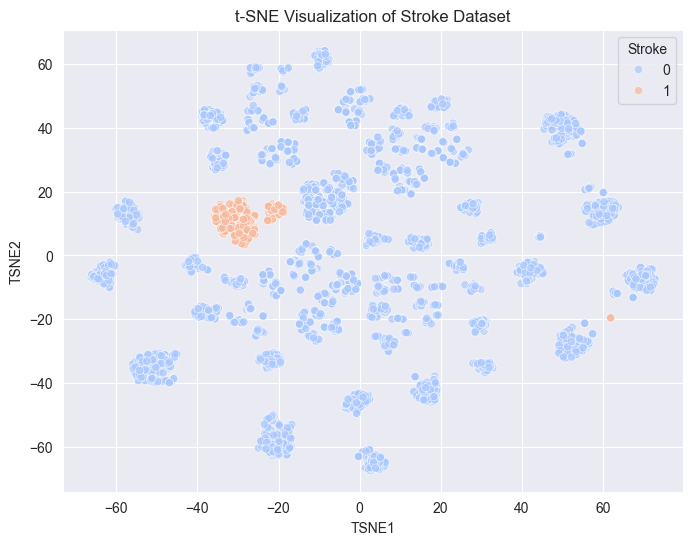

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_tsne = tsne.fit_transform(df_encoded_scaled)

df_tsne = pd.DataFrame()
df_tsne['TSNE1'] = X_tsne[:, 0]
df_tsne['TSNE2'] = X_tsne[:, 1]
df_tsne['Stroke'] = y.values 

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Stroke', palette='coolwarm', alpha=0.7)
plt.title('t-SNE Visualization of Stroke Dataset')
plt.show()

As we can see above, UMAP visualization is much better than PCA. We can see that the data is not linearly separable, but we can see some clusters. Let's try to use clustering algorithms to find these clusters.

# Clustering

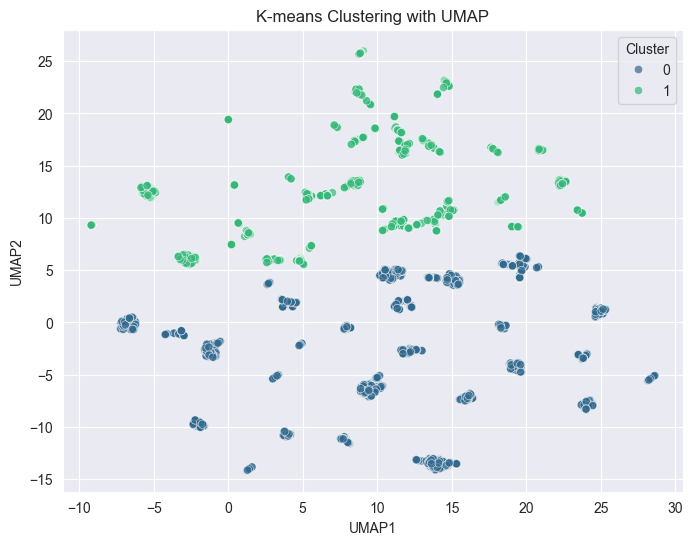

In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
df_umap['Cluster'] = kmeans.fit_predict(df_umap[['UMAP1', 'UMAP2']])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='Cluster', palette='viridis', alpha=0.7)
plt.title("K-means Clustering with UMAP")
plt.show()

As we can see above, K-means clustering is not very good as we have 1 small group of people with stroke and many small groups of people without stroke. Let's try to use DBSCAN clustering algorithm which is better with that type of clusters.

In [30]:
#dopasowanie DBSCAN do danych UMAP
from sklearn.cluster import DBSCAN
from sklearn.cluster import DBSCAN
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dbscan = DBSCAN(eps=0.7, min_samples=5)
clusters = dbscan.fit_predict(umap_result)

df_umap = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])
df_umap['cluster'] = clusters
df_umap['stroke'] = y.values
ct = pd.crosstab(df_umap['cluster'], df_umap['stroke'])
print(ct)

stroke     0    1
cluster          
0          0  247
1        138    1
2        152    1
3        154    0
4         85    0
5         65    0
6         91    0
7         22    0
8        102    0
9        115    0
10       228    0
11        86    0
12        95    0
13       301    0
14       214    0
15        69    0
16        36    0
17       109    0
18        37    0
19        46    0
20        66    0
21       228    0
22       116    0
23        77    0
24       144    0
25        28    0
26       107    0
27        76    0
28       173    0
29        68    0
30       109    0
31        30    0
32        49    0
33       117    0
34        59    0
35        95    0
36        91    0
37        26    0
38        42    0
39        70    0
40        13    0
41        46    0
42        42    0
43        99    0
44        58    0
45        70    0
46        68    0
47        74    0
48       111    0
49        34    0
50        41    0
51        53    0
52        56    0
53        

The dbscan clustering algorithm has found clusters when almost all people with stroke are. In the rest, almost 99% of people are without stroke. Let's visualize the results.

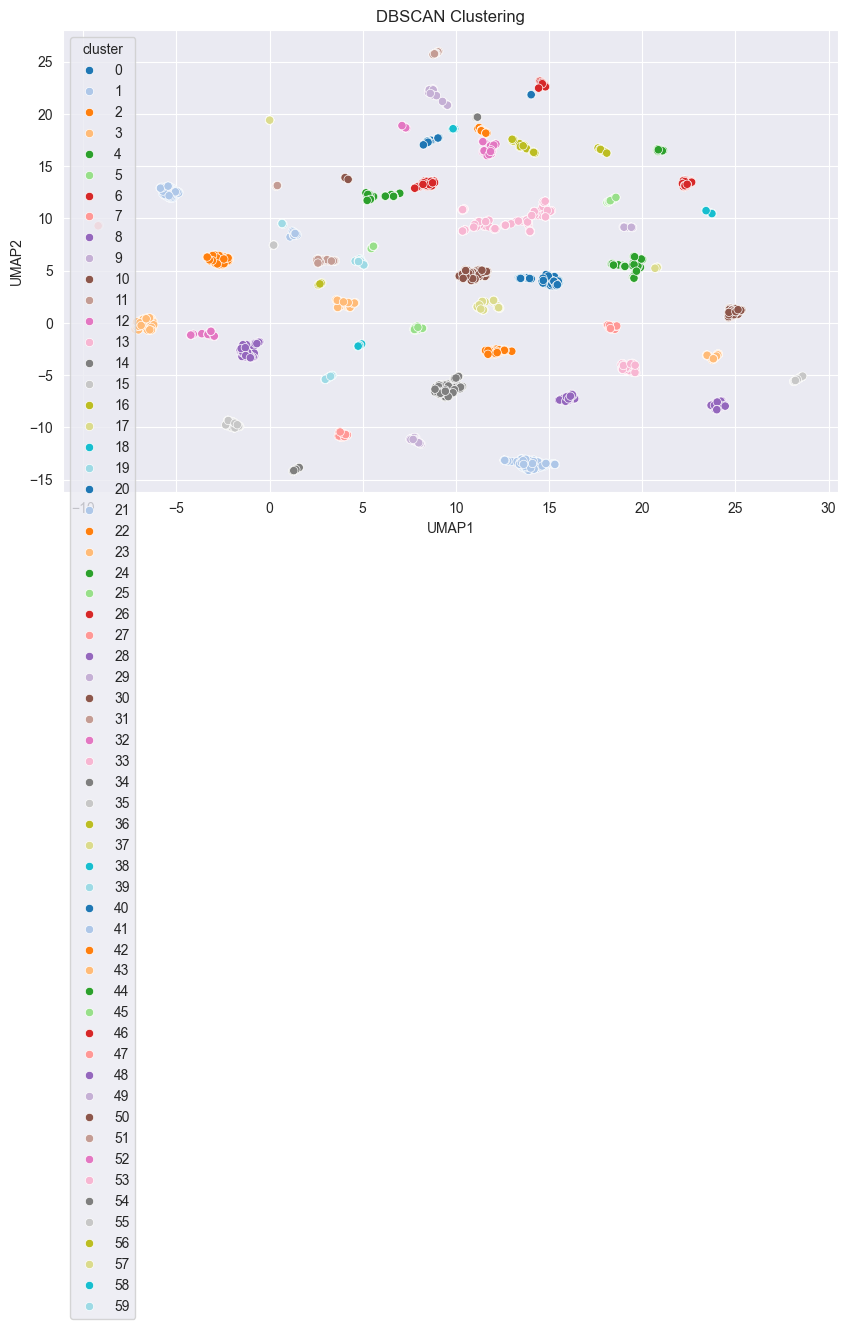

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='cluster', palette='tab20')
plt.title("DBSCAN Clustering")
plt.show()

# ARI for KMeans and DBSCAN

In [32]:
from sklearn.metrics import adjusted_rand_score

# ARI for KMeans
ari_kmeans = adjusted_rand_score(y, kmeans.labels_)
print(f"Adjusted Rand Index (KMeans): {ari_kmeans:.4f}")

# ARI for DBSCAN
ari_dbscan = adjusted_rand_score(y, dbscan.labels_)
print(f"Adjusted Rand Index (DBSCAN): {ari_dbscan:.4f}")

Adjusted Rand Index (KMeans): -0.0175
Adjusted Rand Index (DBSCAN): 0.0052


As we can see above, the ARI for KMeans is negative (so it is worse than a random guesser) and for DBSCAN is 0.005. 
This means that the clustering algorithms are not able  to find any clusters in the data, because the data likely does not contain well-separated natural 
groupings that align with the target variable (stroke).

To detect stroke effectively, supervised learning (like classification models) is more appropriate than unsupervised clustering.